In [48]:
import torch
import Tournament
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from importlib import reload
reload(Tournament)
sce = Tournament.symmetric_cross_entropy
Tournament = Tournament.Tournament
nn = torch.nn
F = nn.functional

In [4]:
train_dataset = datasets.CIFAR100('../data', train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ]))
test_dataset = datasets.CIFAR100('../data', train=False,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ]))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
class_count = torch.max(torch.tensor(train_dataset.targets)) + 1
image_shape = train_dataset[0][0].shape
print(image_shape, class_count)

100%|██████████| 169M/169M [00:08<00:00, 19.7MB/s] 


torch.Size([3, 32, 32]) tensor(100)


In [ ]:

class MobileNetBackbone(nn.Module):
    def __init__(self, device='cpu', output_dim=128):
        super(MobileNetBackbone, self).__init__()
        self.device = device
        # Load pretrained MobileNetV3
        mobilenet = models.mobilenet_v3_large(pretrained=True)

        # Remove the classifier head
        self.features = mobilenet.features  # CNN feature extractor
        self.avgpool = mobilenet.avgpool    # AdaptiveAvgPool2d
        self.flatten = nn.Flatten()

        # Replace classifier with a projection to 128-dim
        self.fc = nn.Sequential(
            nn.Linear(mobilenet.classifier[0].in_features, output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

class CNNModel(torch.nn.Module):
    def __init__(self, device = 'cpu'):
        super(CNNModel, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(image_shape[0], 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        return x
class MLPModel(torch.nn.Module):
    def __init__(self, device = 'cpu'):
        super(MLPModel, self).__init__()
        self.device = device
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(torch.prod(image_shape), 256)
        self.fc2 = nn.Linear(256, 128)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return x

class BaseModel(torch.nn.Module):
    def __init__(self, model, device = 'cpu'):
        super(BaseModel, self).__init__()
        self.device = device
        self.model = model
        self.fc2 = nn.Linear(128, class_count)
        self.batchnorm = nn.BatchNorm1d(class_count)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, train = False):
        x = self.model(x)
        x = self.fc2(x)
        x = self.batchnorm(x)
        x = self.sigmoid(x)
        if train:
            x = F.softmax(x, dim=1)
        return x

class MidModel(torch.nn.Module):
    def __init__(self, model, device = 'cpu'):
        super(MidModel, self).__init__()
        self.device = device
        self.model = model
        self.fc2 = nn.Linear(128, 50*99)
        self.fc3 = nn.Linear(50*99, class_count)
        self.batchnorm2 = nn.BatchNorm1d(50*99)
        self.batch_norm3 = nn.BatchNorm1d(class_count)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, train = False):
        x = self.model(x)
        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.batch_norm3(x)
        x = self.sigmoid(x)
        if train:
            x = F.softmax(x, dim=1)
        return x

class TournamentModel(torch.nn.Module):
    def __init__(self, model, device = 'cpu'):
        super(TournamentModel, self).__init__()
        self.device = device
        self.model = model
        self.tournament = Tournament(num_classes=class_count)
        self.fc2 = nn.Linear(128, self.tournament.num_edges)
        self.batchnorm = nn.BatchNorm1d(self.tournament.num_edges)
        # self.batchnorm = nn.Identity(self.tournament.num_edges)
        self.sigmoid = nn.Sigmoid()
        self.layers = [self.model, self.fc2, self.batchnorm, self.sigmoid]
        self.middle = nn.Sequential(*self.layers)
    def forward(self, x, train = False):
        x = self.middle(x)
        x = self.tournament(x)
        if train:
            x = F.softmax(x, dim=1)
        return x


In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), F.one_hot(target.to(device), num_classes=class_count).float()
        optimizer.zero_grad()
        output = model(data, train=True)
        # print(output.min(), output.max())
        loss = sce(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'loss': loss.item()})
def test_basic(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target_oh = F.one_hot(target, num_classes=class_count).float()
            output_sm = model(data, train=True)
            output = model(data)
            test_loss += sce(output_sm, target_oh, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return test_loss, accuracy

def clip(data, threshold = .6):
    data = data - threshold
    data = torch.clamp(data, 0, (1-threshold))
    data = data * (1/(1-threshold))
    return data
clip_test = torch.linspace(0,1,25)
print(clip(clip_test))


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0625, 0.1667, 0.2708,
        0.3750, 0.4792, 0.5833, 0.6875, 0.7917, 0.8958, 1.0000])


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = CNNModel
# backbone = MLPModel
# base_model = BaseModel(model = backbone(), device = device)
mid_model = MidModel(model = backbone(), device = device)
# tournament_model = TournamentModel(model = backbone(), device = device)
# optimizer_base = torch.optim.Adam(base_model.parameters(), lr=0.001)
optimizer_mid = torch.optim.Adam(mid_model.parameters(), lr=0.001)
# optimizer_tournament = torch.optim.Adam(tournament_model.parameters(), lr=0.001)
num_epochs = 10

In [9]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch}: Base Model")
    train(base_model, device, train_loader, optimizer_base, epoch)
    test_basic(base_model, device, test_loader)

Epoch 0: Base Model


100%|██████████| 782/782 [00:56<00:00, 13.79it/s, loss=0.0523]



Test set: Average loss: 5.2136, Accuracy: 2559/10000 (25.59%)

Epoch 1: Base Model


100%|██████████| 782/782 [01:00<00:00, 12.87it/s, loss=0.0514]



Test set: Average loss: 5.1438, Accuracy: 3128/10000 (31.28%)

Epoch 2: Base Model


100%|██████████| 782/782 [01:00<00:00, 12.93it/s, loss=0.0512]



Test set: Average loss: 5.0733, Accuracy: 3402/10000 (34.02%)

Epoch 3: Base Model


100%|██████████| 782/782 [01:00<00:00, 13.01it/s, loss=0.0504]



Test set: Average loss: 5.0352, Accuracy: 3509/10000 (35.09%)

Epoch 4: Base Model


100%|██████████| 782/782 [00:58<00:00, 13.35it/s, loss=0.0501]



Test set: Average loss: 5.0153, Accuracy: 3380/10000 (33.80%)

Epoch 5: Base Model


100%|██████████| 782/782 [00:57<00:00, 13.48it/s, loss=0.051] 



Test set: Average loss: 4.9972, Accuracy: 3562/10000 (35.62%)

Epoch 6: Base Model


100%|██████████| 782/782 [00:57<00:00, 13.51it/s, loss=0.05]  



Test set: Average loss: 4.9675, Accuracy: 3729/10000 (37.29%)

Epoch 7: Base Model


100%|██████████| 782/782 [00:58<00:00, 13.36it/s, loss=0.0493]



Test set: Average loss: 4.9596, Accuracy: 3695/10000 (36.95%)

Epoch 8: Base Model


100%|██████████| 782/782 [00:58<00:00, 13.36it/s, loss=0.0492]



Test set: Average loss: 4.9613, Accuracy: 3730/10000 (37.30%)

Epoch 9: Base Model


100%|██████████| 782/782 [00:57<00:00, 13.50it/s, loss=0.0488]



Test set: Average loss: 4.9453, Accuracy: 3848/10000 (38.48%)



In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch}: Mid Model")
    train(mid_model, device, train_loader, optimizer_mid, epoch)
    test_basic(mid_model, device, test_loader)


In [13]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch}: Tournament Model")
    train(tournament_model, device, train_loader, optimizer_tournament, epoch)
    test_basic(tournament_model, device, test_loader)

Epoch 0: Tournament Model


100%|██████████| 782/782 [02:12<00:00,  5.92it/s, loss=0.0536]



Test set: Average loss: 5.3800, Accuracy: 2918/10000 (29.18%)

Epoch 1: Tournament Model


100%|██████████| 782/782 [02:12<00:00,  5.89it/s, loss=0.0536]



Test set: Average loss: 5.3432, Accuracy: 3479/10000 (34.79%)

Epoch 2: Tournament Model


100%|██████████| 782/782 [02:21<00:00,  5.52it/s, loss=0.0531]



Test set: Average loss: 5.3292, Accuracy: 3809/10000 (38.09%)

Epoch 3: Tournament Model


100%|██████████| 782/782 [02:22<00:00,  5.48it/s, loss=0.053] 



Test set: Average loss: 5.3204, Accuracy: 4002/10000 (40.02%)

Epoch 4: Tournament Model


100%|██████████| 782/782 [02:18<00:00,  5.66it/s, loss=0.0529]



Test set: Average loss: 5.3151, Accuracy: 4200/10000 (42.00%)

Epoch 5: Tournament Model


100%|██████████| 782/782 [02:15<00:00,  5.78it/s, loss=0.0528]



Test set: Average loss: 5.3135, Accuracy: 4243/10000 (42.43%)

Epoch 6: Tournament Model


100%|██████████| 782/782 [02:14<00:00,  5.80it/s, loss=0.053] 



Test set: Average loss: 5.3129, Accuracy: 4195/10000 (41.95%)

Epoch 7: Tournament Model


100%|██████████| 782/782 [02:14<00:00,  5.81it/s, loss=0.0528]



Test set: Average loss: 5.3146, Accuracy: 4227/10000 (42.27%)

Epoch 8: Tournament Model


100%|██████████| 782/782 [02:10<00:00,  6.00it/s, loss=0.0528]



Test set: Average loss: 5.3122, Accuracy: 4365/10000 (43.65%)

Epoch 9: Tournament Model


100%|██████████| 782/782 [02:08<00:00,  6.08it/s, loss=0.0527]



Test set: Average loss: 5.3119, Accuracy: 4358/10000 (43.58%)



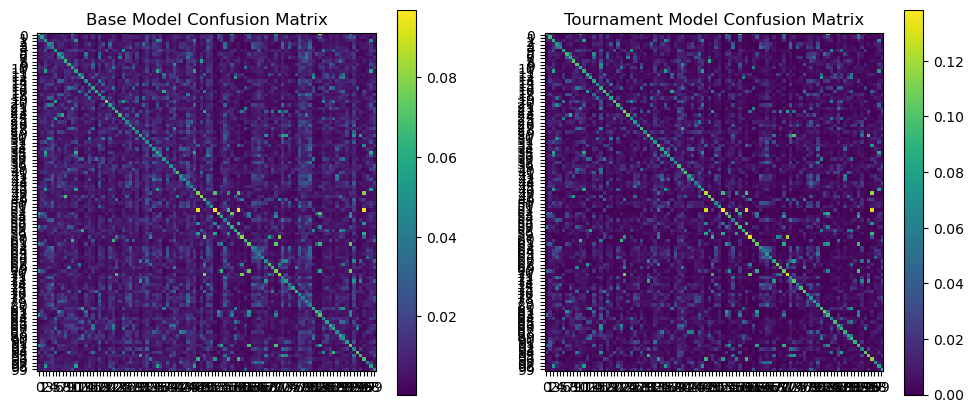

In [14]:
confidences_base = torch.zeros((class_count,class_count))
confidences_tournament = torch.zeros((class_count,class_count))
threshold = .8
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output_base = base_model(data,train=False)
        # output_base = clip(output_base, threshold = threshold)
        output_tournament = tournament_model(data,train=False)
        output_tournament = clip(output_tournament, threshold = threshold)
        for i in range(class_count):
            mask = (target == i)
            if mask.sum() > 0:
                confidences_base[i] += output_base[mask].sum(0).cpu()
                confidences_tournament[i] += output_tournament[mask].sum(0).cpu()
confidences_base /= confidences_base.sum(1, keepdim=True)
confidences_tournament /= confidences_tournament.sum(1, keepdim=True)
# vmin = min(confidences_base.log().min(), confidences_tournament.log().min())
vmin, vmin_t = confidences_base.min(), confidences_tournament.min()
# vmax = max(confidences_base.log().max(), confidences_tournament.log().max())
vmax, vmax_t = confidences_base.max(), confidences_tournament.max()
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.xticks(list(range(class_count)))
plt.yticks(list(range(class_count)))
plt.title('Base Model Confusion Matrix')
plt.imshow(confidences_base, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.subplot(1,2,2)
plt.xticks(list(range(class_count)))
plt.yticks(list(range(class_count)))
plt.title('Tournament Model Confusion Matrix')
plt.imshow(confidences_tournament, vmin=vmin_t, vmax=vmax_t)
plt.colorbar()
plt.show()

tensor(0.0043) tensor(0.2498)


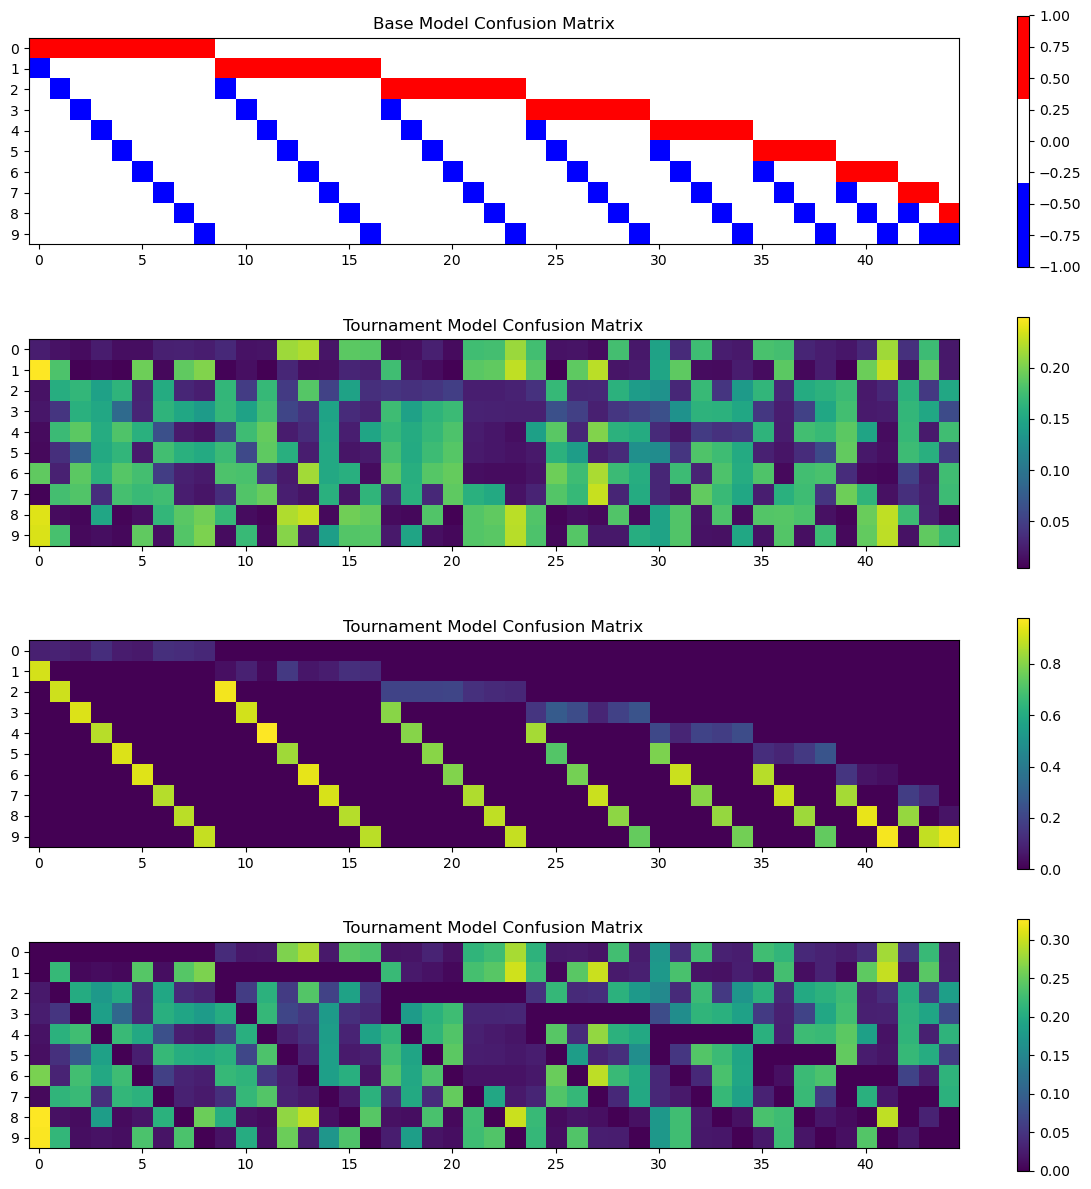

In [ ]:
def ternary(x):
    x = x.clone()
    # x[x < .4] = 1
    # x[(x >= .4) & (x < .6)] = 0.0
    # x[x >= .6] = -1
    return x
confidences_base = torch.zeros((class_count,class_count))
confidences_tournament = torch.zeros((class_count,tournament_model.tournament.num_edges))
perfect_tournament = tournament_model.tournament.gt.clone()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output_base = base_model(data,train=False)
        output_tournament = tournament_model.middle(data)
        # output_tournament = ternary(output_tournament)
        for i in range(class_count):
            mask = (target == i)
            if mask.sum() > 0:
                confidences_base[i] += output_base[mask].sum(0).cpu()
                confidences_tournament[i] += output_tournament[mask].sum(0).cpu()
# confidences_base /= confidences_base.sum(1, keepdim=True)
confidences_tournament /= confidences_tournament.sum(0, keepdim=True)
vmin = confidences_tournament.min()
vmax = confidences_tournament.max()
# I need a trinary color map for the perfect tournament
cmap = plt.get_cmap('bwr', 3)
plt.figure(figsize=(15,15))
plt.subplot(4,1,1)
# plt.xticks(list(range(class_count)))
plt.yticks(list(range(class_count)))
plt.title('Base Model Confusion Matrix')
# plt.imshow(perfect_tournament, vmin=vmin, vmax=vmax, cmap=cmap)
plt.imshow(perfect_tournament, cmap=cmap)
plt.colorbar()
plt.subplot(4,1,2)
# plt.xticks(list(range(class_count)))
plt.yticks(list(range(class_count)))
plt.title('Tournament Model Confusion Matrix')
plt.imshow(confidences_tournament, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.subplot(4,1,3)
# plt.xticks(list(range(class_count)))
plt.yticks(list(range(class_count)))
plt.title('Tournament Model Confusion Matrix')
masked = confidences_tournament * perfect_tournament.abs()
masked /= masked.sum(0, keepdim=True)
plt.imshow(masked, vmin=masked.min(), vmax=masked.max())
plt.colorbar()
plt.subplot(4,1,4)
# plt.xticks(list(range(class_count)))
plt.yticks(list(range(class_count)))
plt.title('Tournament Model Confusion Matrix')
masked = confidences_tournament * (1-perfect_tournament.abs())
masked /= masked.sum(0, keepdim=True)
plt.imshow(masked, vmin=masked.min(), vmax=masked.max())
plt.colorbar()
plt.show()

/var/folders/6d/1k2xm78s2c17nwkp_3wr7sbm0000gq/T/ipykernel_81264/668599011.py:11: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1752197847897/work/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.bincount(selected_values, minlength=K)


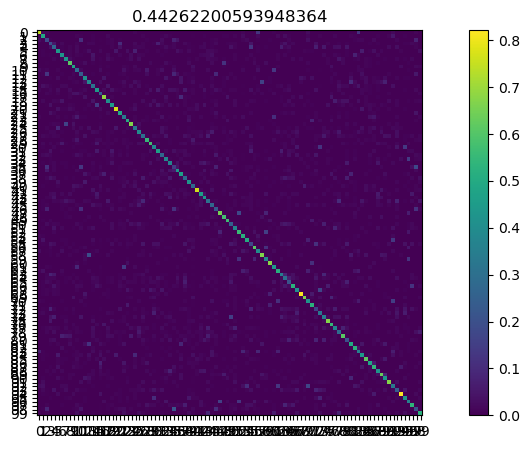

In [47]:
# def get_gt_stuff(num_classes):
#     ground_truth_indicies, ground_truth_values = [],[]
#     for k in range(num_classes):
#         i,v = torch.where(tournament_model.tournament.perms == k)
#         ground_truth_indicies.append(i)
#         ground_truth_values.append(v)
#     return torch.stack(ground_truth_values).T, torch.stack(ground_truth_indicies).T
def select_by_binary_indices(data_array, K):
    def func(binary_array):
        selected_values = data_array[torch.arange(binary_array.shape[0]), binary_array].to(torch.int64)
        counts = torch.bincount(selected_values, minlength=K)
        # m = torch.max(counts)
        # mask = counts == m
        # c = mask.sum()
        # condition = (c == 1).to(torch.int32)
        # out = condition * (counts.argmax()+1) - 1
        return F.one_hot(counts.to(torch.float32).argmax(0), num_classes=K)
    return torch.func.vmap(func)
# ground_truth_val, ground_truth_ind = get_gt_stuff(class_count)
def assign(x):
    x = x.clone()
    x[x <= .5] = 0
    x[x > .5] = 1
    out = select_by_binary_indices(tournament_model.tournament.perms, class_count)(x.to(torch.int64))
    return out
confidences_tournament = torch.zeros((class_count,class_count))
threshold = .8
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        # output_base = clip(output_base, threshold = threshold)
        output_tournament = tournament_model.middle(data)
        output_tournament = assign(output_tournament)
        for i in range(class_count):
            mask = (target == i)
            if mask.sum() > 0:
                confidences_tournament[i] += output_tournament[mask].to(torch.float32).sum(0).cpu()
confidences_base /= confidences_base.sum(1, keepdim=True)
# confidences_tournament = confidences_tournament.softmax(1)
confidences_tournament /= confidences_tournament.sum(0, keepdim=True)
# vmin = min(confidences_base.log().min(), confidences_tournament.log().min())
vmin, vmin_t = confidences_base.min(), confidences_tournament.min()
# vmax = max(confidences_base.log().max(), confidences_tournament.log().max())
vmax, vmax_t = confidences_base.max(), confidences_tournament.max()
plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.xticks(list(range(class_count)))
# plt.yticks(list(range(class_count)))
# plt.title('Base Model Confusion Matrix')
# plt.imshow(confidences_base, vmin=vmin, vmax=vmax)
# plt.colorbar()
plt.subplot(1,1,1)
plt.xticks(list(range(class_count)))
plt.yticks(list(range(class_count)))
plt.title(f'{confidences_tournament.trace()/confidences_tournament.sum()}')
plt.imshow(confidences_tournament, vmin=vmin_t, vmax=vmax_t)
plt.colorbar()
plt.show()

In [21]:
tournament_model.parameters.size()

AttributeError: 'function' object has no attribute 'size'

In [24]:
# Helper to count parameters (total and trainable)
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

# Example usage with your tournament_model
total, trainable = count_params(tournament_model)
print(f"Total parameters: {total:,}")
print(f"Trainable parameters: {trainable:,}")

# Per-parameter breakdown (name, count, trainable/frozen)
for name, param in tournament_model.named_parameters():
    param_count = param.numel()
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name:40} {param_count:>10,} ({status})")

Total parameters: 1,003,970
Trainable parameters: 1,003,970
model.conv1.weight                              864 (Trainable)
model.conv1.bias                                 32 (Trainable)
model.conv2.weight                           18,432 (Trainable)
model.conv2.bias                                 64 (Trainable)
model.conv3.weight                           73,728 (Trainable)
model.conv3.bias                                128 (Trainable)
model.fc1.weight                            262,144 (Trainable)
model.fc1.bias                                  128 (Trainable)
fc2.weight                                  633,600 (Trainable)
fc2.bias                                      4,950 (Trainable)
batchnorm.weight                              4,950 (Trainable)
batchnorm.bias                                4,950 (Trainable)


In [ ]:
adjklsfhas = torch